In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent
import pandas as pd

## Loading Data

In [1]:
resnet20_mean = torch.tensor([0.4914, 0.4822, 0.4465])
resnet20_std = torch.tensor([0.2023, 0.1994, 0.2010])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(resnet20_mean, resnet20_std) 
])

full_train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

train_size = int(0.8 * len(full_train_dataset))  # 80% for training
val_size = len(full_train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


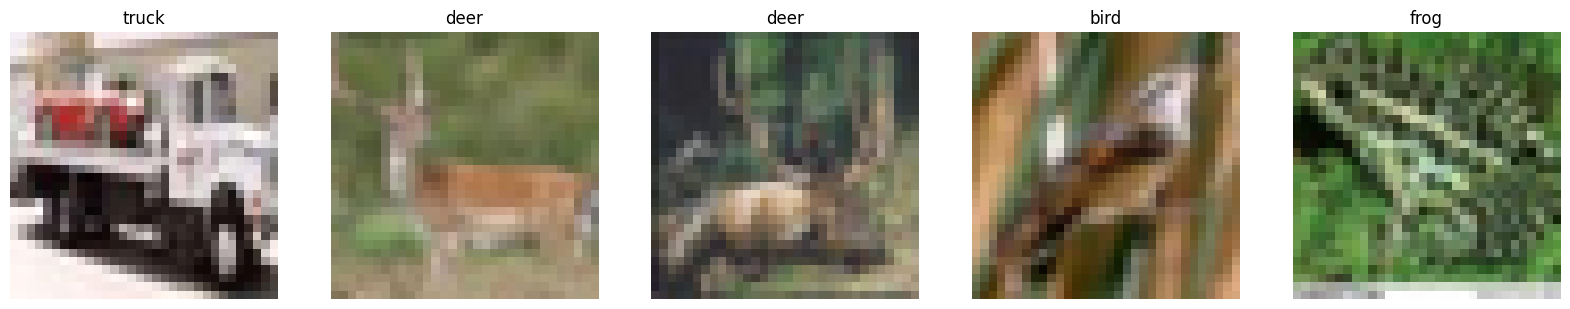

In [4]:
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def undo_normalization(img, mean, std):
    img = img * std[None, :, None, None] + mean[None, :, None, None]
    return img

def show_random_images(dataset, class_names):
    random.seed(42)
    indices = random.sample(range(len(dataset)), 5)
    images, labels = zip(*[dataset[i] for i in indices])
    fig, axes = plt.subplots(1, 5, figsize=(20, 10))
    
    for i, (img, label) in enumerate(zip(images, labels)):
        img = undo_normalization(img, resnet20_mean, resnet20_std).squeeze(0).permute(1, 2, 0).clamp(0, 1).numpy()
        axes[i].imshow(img)
        axes[i].set_title(class_names[label])
        axes[i].axis('off')
    
    plt.show()

show_random_images(full_train_dataset, CLASS_NAMES)

## Loading Target Model

In [9]:
target_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)

target_model = target_model.to('cuda')

Using cache found in C:\Users\ALI/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


In [16]:
def evaluate_accuracy(model, test_loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

accuracy = evaluate_accuracy(target_model, test_loader)

print(f"Accuracy on CIFAR-10 test set: {accuracy:.2f}%")

100%|██████████| 157/157 [00:02<00:00, 61.03it/s]

Accuracy on CIFAR-10 test set: 92.59%


## FGSM and PGD Attack

In [7]:
def perform_classic_attack(model, test_loader, epsilon=0.01, pgd=True):
    model.eval()
    correct_clean = 0
    correct_fgsm = 0
    correct_pgd = 0
    total = 0

    for images, labels in tqdm(test_loader, desc="Performing Classic Attack"):
        images, labels = images.cuda(), labels.cuda()

        # Clean predictions
        output = model(images)
        _, predicted = output.max(1)
        total += labels.size(0)
        correct_clean += predicted.eq(labels).sum().item()

        # FGSM Adversarial Example
        images_fgm = fast_gradient_method(model, images, epsilon, np.inf)
        output_fgm = model(images_fgm)
        _, predicted_fgm = output_fgm.max(1)
        correct_fgsm += predicted_fgm.eq(labels).sum().item()

        if pgd:
            # PGD Adversarial Example
            images_pgd = projected_gradient_descent(model, images, epsilon, 0.01, 40, np.inf)
            output_pgd = model(images_pgd)
            _, predicted_pgd = output_pgd.max(1)
            correct_pgd += predicted_pgd.eq(labels).sum().item()

    acc_clean = 100.0 * correct_clean / total
    acc_fgsm = 100.0 * correct_fgsm / total
    acc_pgd = 100.0 * correct_pgd / total if pgd else None

    attack_success_fgsm = 100.0 - acc_fgsm
    attack_success_pgd = 100.0 - acc_pgd if pgd else None

    print(f"Clean Accuracy: {acc_clean:.2f}%")
    print(f"FGSM Accuracy: {acc_fgsm:.2f}%")
    print(f"FGSM Attack Success Rate: {attack_success_fgsm:.2f}%")

    if pgd:
        print(f"PGD Accuracy: {acc_pgd:.2f}%")
        print(f"PGD Attack Success Rate: {attack_success_pgd:.2f}%")

    return acc_clean, acc_fgsm, acc_pgd

In [10]:
epsilon = 0.01
acc_clean, acc_fgsm, acc_pgd = perform_classic_attack(target_model, test_loader, epsilon)

Performing Classic Attack: 100%|██████████| 79/79 [01:37<00:00,  1.23s/it]

Clean Accuracy: 92.59%
FGSM Accuracy: 68.71%
FGSM Attack Success Rate: 31.29%
PGD Accuracy: 58.92%
PGD Attack Success Rate: 41.08%


In [11]:
import torch
import random
import matplotlib.pyplot as plt
import numpy as np
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent

def plot_images_with_adversarial_examples(model, test_loader, epsilon=0.01):
    random.seed(42)
    model.eval()

    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    indices = random.sample(range(len(images)), 5)

    selected_images = images[indices].cuda()
    selected_labels = labels[indices].cuda()

    images_fgsm = fast_gradient_method(model, selected_images, epsilon, np.inf)
    images_pgd = projected_gradient_descent(model, selected_images, epsilon, 0.01, 40, np.inf)

    with torch.no_grad():
        preds_fgsm = model(images_fgsm).argmax(dim=1)
        preds_pgd = model(images_pgd).argmax(dim=1)

    images_fgsm = images_fgsm.cpu()
    images_pgd = images_pgd.cpu()

    images_fgsm = undo_normalization(images_fgsm, resnet20_mean, resnet20_std)
    images_pgd = undo_normalization(images_pgd, resnet20_mean, resnet20_std)

    selected_images = selected_images.cpu()
    selected_images = undo_normalization(selected_images, resnet20_mean, resnet20_std)

    images_fgsm = torch.clamp(images_fgsm, 0, 1)
    images_pgd = torch.clamp(images_pgd, 0, 1)
    selected_images = torch.clamp(selected_images, 0, 1)

    fig, axes = plt.subplots(3, 5, figsize=(15, 9))

    for i in range(5):
        ax = axes[0, i]
        ax.imshow(selected_images[i].permute(1, 2, 0).detach().numpy())
        ax.set_title(f"Label: {CLASS_NAMES[selected_labels[i]]}")
        ax.axis('off')

        ax = axes[1, i]
        ax.imshow(images_fgsm[i].permute(1, 2, 0).detach().numpy())
        ax.set_title(f"FGSM Attack Pred: {CLASS_NAMES[preds_fgsm[i]]}")
        ax.axis('off')

        ax = axes[2, i]
        ax.imshow(images_pgd[i].permute(1, 2, 0).detach().numpy())
        ax.set_title(f"PGD Attck Pred: {CLASS_NAMES[preds_pgd[i]]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

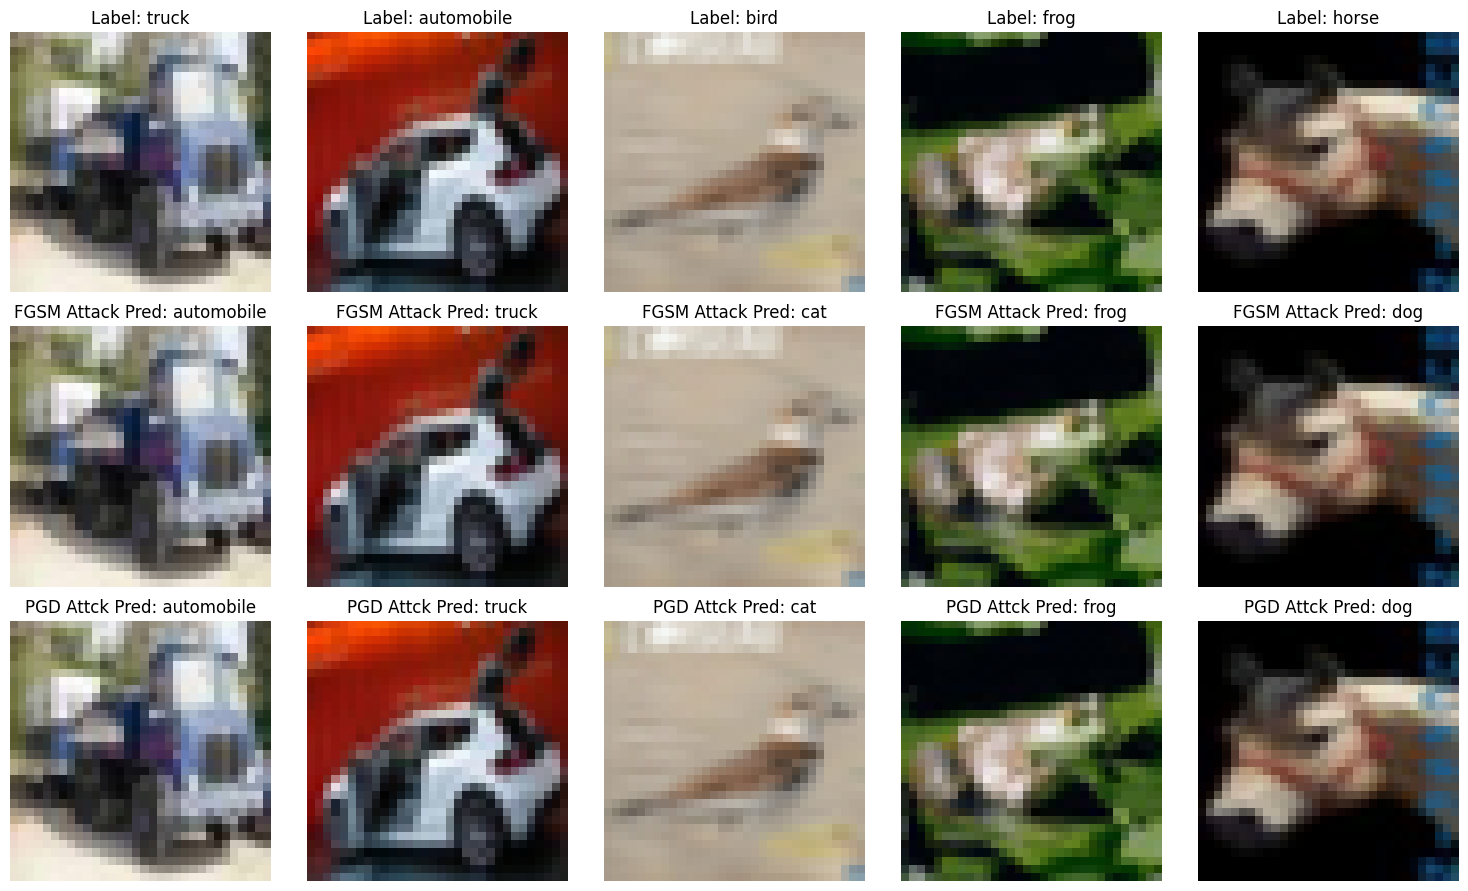

In [12]:
plot_images_with_adversarial_examples(target_model, test_loader, epsilon=0.01)

In [13]:
epsilon = 8 / (255 * resnet20_std.max().item())
acc_clean, acc_fgsm, acc_pgd = perform_classic_attack(target_model, test_loader, epsilon)

Performing Classic Attack: 100%|██████████| 79/79 [01:34<00:00,  1.19s/it]

Clean Accuracy: 92.59%
FGSM Accuracy: 18.49%
FGSM Attack Success Rate: 81.51%
PGD Accuracy: 4.32%
PGD Attack Success Rate: 95.68%


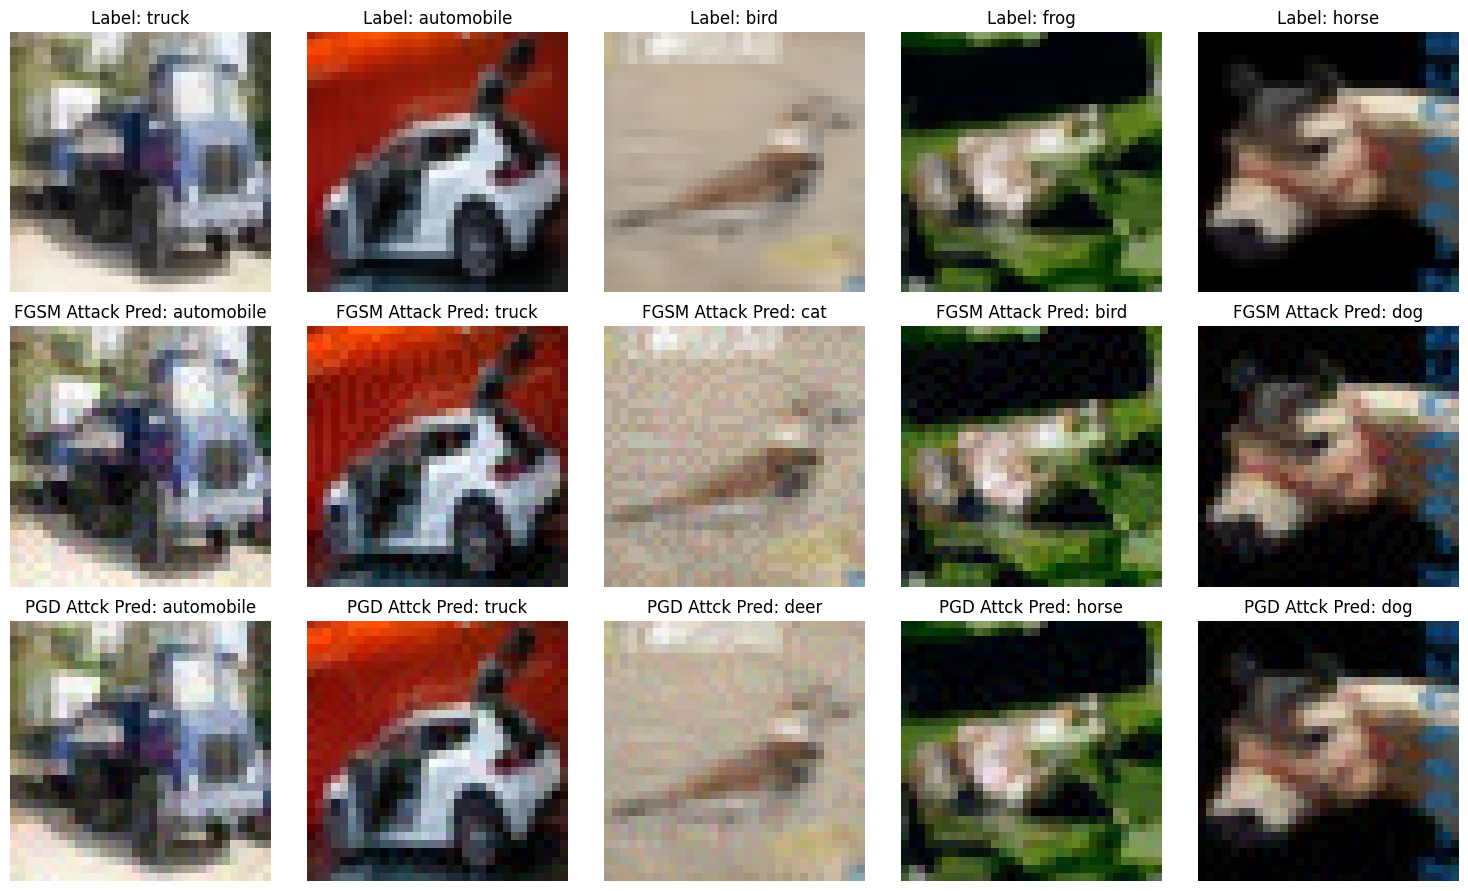

In [14]:
plot_images_with_adversarial_examples(target_model, test_loader, epsilon=epsilon)

## AdvGAN

### Discriminator

In [4]:
class Discriminator_CIFAR10(nn.Module):
    def __init__(self):
        super(Discriminator_CIFAR10, self).__init__()

        self.conv1 = nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1)
        self.in2 = nn.InstanceNorm2d(16)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1)
        self.in3 = nn.InstanceNorm2d(32)

        self.fc = nn.Linear(4 * 4 * 32, 1)  

    def forward(self, x):

        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)  

        x = F.leaky_relu(self.in2(self.conv2(x)), negative_slope=0.2)  
        x = F.leaky_relu(self.in3(self.conv3(x)), negative_slope=0.2)  

        x = x.view(x.size(0), -1)  

        x = self.fc(x)  

        return x

### Generator

In [5]:
class Generator_CIFAR10_UNet(nn.Module):
    def __init__(self):
        super(Generator_CIFAR10_UNet, self).__init__()
        
        # Encoder
        # Input: 32x32x3 -> 16x16x32
        self.enc1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        
        # 16x16x32 -> 8x8x64
        self.enc2 = nn.Sequential(
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64)
        )
        
        # 8x8x64 -> 4x4x128
        self.enc3 = nn.Sequential(
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128)
        )
        
        # 4x4x128 -> 2x2x256
        self.enc4 = nn.Sequential(
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256)
        )
        
        # Decoder
        # 2x2x256 -> 4x4x128
        self.dec1 = nn.Sequential(
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.Dropout(0.5)
        )
        
        # 4x4x(128+128) -> 8x8x64
        self.dec2 = nn.Sequential(
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.Dropout(0.5)
        )
        
        # 8x8x(64+64) -> 16x16x32
        self.dec3 = nn.Sequential(
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32)
        )
        
        # 16x16x(32+32) -> 32x32x3
        self.dec4 = nn.Sequential(
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)      # 32x32x3 -> 16x16x32
        e2 = self.enc2(e1)     # 16x16x32 -> 8x8x64
        e3 = self.enc3(e2)     # 8x8x64 -> 4x4x128
        e4 = self.enc4(e3)     # 4x4x128 -> 2x2x256

        # Decoder with skip connections
        d1 = self.dec1(e4)                   # 2x2x256 -> 4x4x128
        d2 = self.dec2(torch.cat([d1, e3], 1))  # 4x4x(128+128) -> 8x8x64
        d3 = self.dec3(torch.cat([d2, e2], 1))  # 8x8x(64+64) -> 16x16x32
        d4 = self.dec4(torch.cat([d3, e1], 1))  # 16x16x(32+32) -> 32x32x3

        return d4


### Training Functions

In [11]:
def adv_loss(logits, target, is_targeted, num_classes=10, kappa=0):
    target_one_hot = torch.eye(num_classes).type(logits.type())[target.long()]
    real = torch.sum(target_one_hot * logits, 1)
    other = torch.max((1 - target_one_hot) * logits - (target_one_hot * 10000), 1)[0]
    kappa = torch.zeros_like(other).fill_(kappa)

    if is_targeted:
        return torch.sum(torch.max(other - real, kappa))
    return torch.sum(torch.max(real - other, kappa))


def train_batch(batch_idx, generator, discriminator, target_model, img, label, target, is_targeted, threshold, criterion_adv, criterion_gan, alpha, beta, gamma, optimizer_generator, optimizer_discriminator, device, num_steps):
    generator.train()
    discriminator.train()
    target_model.eval()

    img_real = img.to(device)
    label = label.to(device)

    valid = torch.ones(img.size(0), 1).to(device)
    fake = torch.zeros(img.size(0), 1).to(device)

    # Train Generator
    optimizer_generator.zero_grad()

    pert = generator(img_real)
    img_fake = pert + img_real

    y_pred = target_model(img_fake)
    if is_targeted:
        y_target = torch.ones_like(label).fill_(target).to(device)
        loss_adv = criterion_adv(y_pred, y_target, is_targeted)
        acc = torch.sum(torch.max(y_pred, 1)[1] == y_target).item() / img.size(0)
    else:
        y_true = label
        loss_adv = criterion_adv(y_pred, y_true, is_targeted)
        acc = torch.sum(torch.max(y_pred, 1)[1] != y_true).item() / img.size(0)

    loss_gan = criterion_gan(discriminator(img_fake), valid)
    loss_hinge = torch.mean(torch.max(torch.zeros(1, ).type(y_pred.type()), 
                                    torch.norm(pert.view(pert.size(0), -1), p=2, dim=1) - threshold))

    loss_generator = gamma * loss_adv + alpha * loss_gan + beta * loss_hinge
    loss_generator.backward()
    optimizer_generator.step()

    # Train Discriminator
    loss_discriminator = 0.0
    d_acc = 0.0
    if batch_idx % num_steps == 0:
        optimizer_discriminator.zero_grad()

        d_real = discriminator(img_real)
        d_fake = discriminator(img_fake.detach())
        
        loss_real = criterion_gan(d_real, valid)
        loss_fake = criterion_gan(d_fake, fake)

        loss_discriminator = 0.5 * (loss_real + loss_fake)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        correct_real = torch.sum((d_real > 0.5).float()).item()
        correct_fake = torch.sum((d_fake < 0.5).float()).item()
        total_samples = img.size(0) * 2  
        d_acc = (correct_real + correct_fake) / total_samples

    return loss_discriminator, loss_generator, loss_gan, loss_adv, loss_hinge, acc, d_acc


def train_gan(generator, discriminator, target_model, train_loader, val_loader, target, is_targeted, threshold, alpha, beta, gamma, device, epochs, num_steps, lr):
    optimizer_generator = optim.Adam(generator.parameters(), lr=lr)
    optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr)
    criterion_adv = adv_loss
    criterion_gan = nn.MSELoss()
    history = {
        "train": {"D_loss": [], "G_loss": [], "GAN_loss": [], "Adv_loss": [], "Hinge_loss": [], "Acc": [], "D_Acc": []},
        "val": {"D_loss": [], "G_loss": [], "GAN_loss": [], "Adv_loss": [], "Hinge_loss": [], "Acc": [], "D_Acc": []},
    }
    best_val_acc = 0.0

    for epoch in range(epochs):
        total_loss_discriminator = 0.0
        total_loss_generator = 0.0
        total_loss_gan = 0.0
        total_loss_adv = 0.0
        total_loss_hinge = 0.0
        total_acc = 0.0
        total_d_acc = 0.0
        discriminator_updates = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
        for batch_idx, (img, label) in enumerate(pbar):
            loss_discriminator, loss_generator, loss_gan, loss_adv, loss_hinge, acc, d_acc = train_batch(
                batch_idx, generator, discriminator, target_model, img, label, target, is_targeted, threshold,
                criterion_adv, criterion_gan, alpha, beta, gamma, optimizer_generator, optimizer_discriminator, device, num_steps
            )

            total_loss_discriminator += loss_discriminator
            total_loss_generator += loss_generator
            total_loss_gan += loss_gan
            total_loss_adv += loss_adv
            total_loss_hinge += loss_hinge
            total_acc += acc
            total_d_acc += d_acc
            if batch_idx % num_steps == 0:
                discriminator_updates += 1

            pbar.set_postfix({
                "D_Loss": f"{total_loss_discriminator / (discriminator_updates or 1):.4f}",
                "G_Loss": f"{total_loss_generator / (batch_idx + 1):.4f}",
                "GAN_Loss": f"{total_loss_gan / (batch_idx + 1):.4f}",
                "Adv_Loss": f"{total_loss_adv / (batch_idx + 1):.4f}",
                "Hinge_Loss": f"{total_loss_hinge / (batch_idx + 1):.4f}",
                "Adv_Acc": f"{total_acc / (batch_idx + 1):.4f}",
                "D_Acc": f"{total_d_acc / (discriminator_updates or 1):.4f}"
            })

        history["train"]["D_loss"].append(total_loss_discriminator.item() / (discriminator_updates or 1))
        history["train"]["G_loss"].append(total_loss_generator.item() / (batch_idx + 1))
        history["train"]["GAN_loss"].append(total_loss_gan.item() / (batch_idx + 1))
        history["train"]["Adv_loss"].append(total_loss_adv.item() / (batch_idx + 1))
        history["train"]["Hinge_loss"].append(total_loss_hinge.item() / (batch_idx + 1))
        history["train"]["Acc"].append(total_acc / (batch_idx + 1))
        history["train"]["D_Acc"].append(total_d_acc / (discriminator_updates or 1))

        val_metrics = validate(generator, discriminator, target_model, target, is_targeted, threshold,
                             val_loader, criterion_gan, criterion_adv, alpha, beta, device)
        for key, value in val_metrics.items():
            history["val"][key].append(value)

        if val_metrics["Acc"] > best_val_acc:
            best_val_acc = val_metrics["Acc"]
            torch.save(generator.state_dict(), "best_generator.pth")

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train - Adv_Acc: {history['train']['Acc'][-1]:.4f}, D_Acc: {history['train']['D_Acc'][-1]:.4f}")
        print(f"Val   - Adv_Acc: {val_metrics['Acc']:.4f}, D_Acc: {val_metrics['D_Acc']:.4f}")
        print("-" * 50)

    return history


def validate(generator, discriminator, target_model, target, is_targeted, threshold, val_loader, criterion_gan, criterion_adv, alpha, beta, device):
    generator.eval()
    discriminator.eval()
    target_model.eval()

    total_loss_discriminator = 0.0
    total_loss_generator = 0.0
    total_loss_gan = 0.0
    total_loss_adv = 0.0
    total_loss_hinge = 0.0
    total_acc = 0.0
    total_d_acc = 0.0
    n = 0

    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validating", leave=False)
        for batch_index, (img, label) in enumerate(pbar):
            img_real = img.to(device)
            label = label.to(device)

            valid = torch.ones(img.size(0), 1).to(device)
            fake = torch.zeros(img.size(0), 1).to(device)

            pert = generator(img_real)
            img_fake = pert + img_real

            # Target model predictions
            y_pred = target_model(img_fake)
            if is_targeted:
                y_target = torch.ones_like(label).fill_(target).to(device)
                loss_adv = criterion_adv(y_pred, y_target, is_targeted)
                acc = torch.sum(torch.max(y_pred, 1)[1] == y_target).item() / img.size(0)
            else:
                y_true = label
                loss_adv = criterion_adv(y_pred, y_true, is_targeted)
                acc = torch.sum(torch.max(y_pred, 1)[1] != y_true).item() / img.size(0)

            d_real = discriminator(img_real)
            d_fake = discriminator(img_fake)

            loss_real = criterion_gan(d_real, valid)
            loss_fake = criterion_gan(d_fake, fake)
            loss_gan = criterion_gan(d_fake, valid)  
            loss_discriminator = 0.5 * (loss_real + loss_fake)

            correct_real = torch.sum((d_real > 0.5).float()).item()
            correct_fake = torch.sum((d_fake < 0.5).float()).item()
            total_samples = img.size(0) * 2  
            d_acc = (correct_real + correct_fake) / total_samples

            loss_hinge = torch.mean(torch.max(torch.zeros(1, ).type(y_pred.type()), 
                                            torch.norm(pert.view(pert.size(0), -1), p=2, dim=1) - threshold))

            total_loss_discriminator += loss_discriminator
            total_loss_generator += loss_adv + alpha * loss_gan + beta * loss_hinge
            total_loss_gan += loss_gan
            total_loss_adv += loss_adv
            total_loss_hinge += loss_hinge
            total_acc += acc
            total_d_acc += d_acc

            pbar.set_postfix({
                "Acc": f"{total_acc / (batch_index+1):.4f}",
                "D_Acc": f"{total_d_acc / (batch_index+1):.4f}"
            })

    return {
        "D_loss": total_loss_discriminator.item() / (batch_index+1),
        "G_loss": total_loss_generator.item() / (batch_index+1),
        "GAN_loss": total_loss_gan.item() / (batch_index+1),
        "Adv_loss": total_loss_adv.item() / (batch_index+1),
        "Hinge_loss": total_loss_hinge.item() / (batch_index+1),
        "Acc": total_acc / (batch_index+1),
        "D_Acc": total_d_acc / (batch_index+1)
    }


### Plot Function

In [12]:
def plot_training_history(history):
    train_history = history['train']
    val_history = history['val']

    plt.figure(figsize=(10, 6))
    plt.plot(train_history['D_loss'], label='Discriminator GAN Loss (train)', linestyle='-', linewidth=2)
    plt.plot(val_history['D_loss'], label='Discriminator GAN Loss (val)', linestyle='--', linewidth=2)
    plt.plot(train_history['GAN_loss'], label='Generator GAN Loss (train)', linestyle='-', linewidth=2)
    plt.plot(val_history['GAN_loss'], label='Generator GAN Loss (val)', linestyle='--', linewidth=2)
    plt.title("Discriminator and Generator GAN Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(train_history['Adv_loss'], label='Adv_loss (train)', linestyle='-', linewidth=2)
    plt.plot(val_history['Adv_loss'], label='Adv_loss (val)', linestyle='--', linewidth=2)
    plt.plot(train_history['Hinge_loss'], label='Hinge_loss (train)', linestyle='-', linewidth=2)
    plt.plot(val_history['Hinge_loss'], label='Hinge_loss (val)', linestyle='--', linewidth=2)
    plt.plot(train_history['GAN_loss'], label='GAN_loss (train)', linestyle='-', linewidth=2)
    plt.plot(val_history['GAN_loss'], label='GAN_loss (val)', linestyle='--', linewidth=2)
    plt.plot(train_history['G_loss'], label='Total_loss (train)', linestyle='-', linewidth=2)
    plt.plot(val_history['G_loss'], label='Total_loss (val)', linestyle='--', linewidth=2)
    plt.title("Generator Loss Components")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(train_history['Acc'], label='Acc (train)', linestyle='-', linewidth=2)
    plt.plot(val_history['Acc'], label='Acc (val)', linestyle='--', linewidth=2)
    plt.title("Generator Accuracy (Acc)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(train_history['D_Acc'], label='D_Acc (train)', linestyle='-', linewidth=2)
    plt.plot(val_history['D_Acc'], label='D_Acc (val)', linestyle='--', linewidth=2)
    plt.title("Discriminator Accuracy (D_Acc)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()


### Perform Attack Function

In [20]:
def perform_advgan_attack(G, target_model, test_loader, class_names, target=None, device='cuda'):
    G.eval()
    target_model.eval()
    correct_clean = 0
    correct_adv = 0
    attack_success = 0
    total = 0
    class_correct_clean = {name: 0 for name in class_names}
    class_correct_adv = {name: 0 for name in class_names}
    class_attack_success = {name: 0 for name in class_names}
    class_total = {name: 0 for name in class_names}
    clean_confidences = []
    adv_confidences = []

    for images, labels in tqdm(test_loader, desc="Performing Generator Attack"):
        images, labels = images.to(device), labels.to(device)
        
        with torch.no_grad():
            output_clean = target_model(images)
            probs_clean = torch.softmax(output_clean, dim=1)
            max_probs_clean, predicted_clean = probs_clean.max(1)
            clean_confidences.extend(max_probs_clean.cpu().numpy())
            correct_clean += predicted_clean.eq(labels).sum().item()
            
            for label in labels.unique():
                class_mask = (labels == label)
                class_name = class_names[label.item()]
                class_correct_clean[class_name] += predicted_clean[class_mask].eq(label).sum().item()
                class_total[class_name] += class_mask.sum().item()

        with torch.no_grad():
            pert = G(images)
            images_adv = images + pert
            output_adv = target_model(images_adv)
            probs_adv = torch.softmax(output_adv, dim=1)
            max_probs_adv, predicted_adv = probs_adv.max(1)
            adv_confidences.extend(max_probs_adv.cpu().numpy())
            correct_adv += predicted_adv.eq(labels).sum().item()

            if target is None:
                attack_success += (~predicted_adv.eq(labels)).sum().item()
                for label in labels.unique():
                    class_mask = (labels == label)
                    class_name = class_names[label.item()]
                    class_correct_adv[class_name] += predicted_adv[class_mask].eq(label).sum().item()
                    class_attack_success[class_name] += (~predicted_adv[class_mask].eq(label)).sum().item()
            else:
                target_tensor = torch.full_like(labels, target)
                attack_success += predicted_adv.eq(target_tensor).sum().item()
                for label in labels.unique():
                    class_mask = (labels == label)
                    class_name = class_names[label.item()]
                    class_correct_adv[class_name] += predicted_adv[class_mask].eq(label).sum().item()
                    class_attack_success[class_name] += predicted_adv[class_mask].eq(target_tensor[class_mask]).sum().item()

        total += labels.size(0)

    acc_clean = 100.0 * correct_clean / total
    acc_adv = 100.0 * correct_adv / total
    attack_success_total = 100.0 * attack_success / total

    results = {
        "Overall": {
            "Clean Accuracy": acc_clean,
            "Adversarial Accuracy": acc_adv,
            "Attack Success Rate": attack_success_total
        }
    }

    for class_name in class_names:
        acc_clean_class = 100.0 * class_correct_clean[class_name] / class_total[class_name]
        acc_adv_class = 100.0 * class_correct_adv[class_name] / class_total[class_name]
        attack_success_class = 100.0 * class_attack_success[class_name] / class_total[class_name]
        results[class_name] = {
            "Clean Accuracy": acc_clean_class,
            "Adversarial Accuracy": acc_adv_class,
            "Attack Success Rate": attack_success_class
        }

    df_results = pd.DataFrame.from_dict(results, orient='index')

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    axes[0].hist(clean_confidences, bins=30, alpha=0.7, label="Clean Data Confidence", color='blue')
    axes[0].set_title("Clean Data Confidence")
    axes[0].set_xlabel("Confidence")
    axes[0].set_ylabel("Frequency")
    axes[0].legend()
    axes[0].grid()

    axes[1].hist(adv_confidences, bins=30, alpha=0.7, label="Adversarial Data Confidence", color='red')
    axes[1].set_title("Adversarial Data Confidence")
    axes[1].set_xlabel("Confidence")
    axes[1].legend()
    axes[1].grid()

    plt.tight_layout()
    plt.show()
    display(df_results)
    

### Plot Images Function

In [19]:
def plot_images_with_advgan_attack(G, target_model, test_loader, device='cuda'):
    random.seed(42)  
    G.eval()
    target_model.eval()

    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    indices = random.sample(range(len(images)), 5)
    selected_images = images[indices].to(device)
    selected_labels = labels[indices].to(device)

    with torch.no_grad():
        pert = G(selected_images)  
        images_adv = selected_images + pert  

    selected_images = undo_normalization(selected_images.cpu(), resnet20_mean, resnet20_std)
    images_adv = undo_normalization(images_adv.cpu(), resnet20_mean, resnet20_std)

    selected_images = torch.clamp(selected_images, 0, 1)
    images_adv = torch.clamp(images_adv, 0, 1)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    for i in range(5):
        ax = axes[0, i]
        ax.imshow(selected_images[i].permute(1, 2, 0).detach().numpy())
        ax.set_title(f"Label: {CLASS_NAMES[selected_labels[i]]}")
        ax.axis('off')

        ax = axes[1, i]
        ax.imshow(images_adv[i].permute(1, 2, 0).detach().numpy())
        ax.set_title(f"Adv. Label: {CLASS_NAMES[target_model(images_adv[i].unsqueeze(0).to(device)).argmax().item()]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    


## Untargetted AdvGAN Attack

In [17]:
EPOCHS = 50
LR = 0.001
THRESHOLD = 8 / (255 * resnet20_std.max().item())
ALPHA = 15
BETA = 8
GAMMA = 0.35
NUM_STEPS = 10
TARGET = None
IS_TARGETED = TARGET is not None

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator_CIFAR10_UNet().to(DEVICE)
discriminator = Discriminator_CIFAR10().to(DEVICE)
target_model = target_model.to(DEVICE)

history = train_gan(
    generator, discriminator, target_model, train_loader, val_loader, TARGET, IS_TARGETED, THRESHOLD,
    ALPHA, BETA, GAMMA, DEVICE, EPOCHS, NUM_STEPS, LR
)

Epoch 1/50
Train - Adv_Acc: 0.8316, D_Acc: 0.5364
Val   - Adv_Acc: 0.8712, D_Acc: 0.6518
--------------------------------------------------


Epoch 2/50
Train - Adv_Acc: 0.8563, D_Acc: 0.6134
Val   - Adv_Acc: 0.8761, D_Acc: 0.5317
--------------------------------------------------


Epoch 3/50
Train - Adv_Acc: 0.8568, D_Acc: 0.5708
Val   - Adv_Acc: 0.8836, D_Acc: 0.4089
--------------------------------------------------


Epoch 4/50
Train - Adv_Acc: 0.8644, D_Acc: 0.6464
Val   - Adv_Acc: 0.8463, D_Acc: 0.7585
--------------------------------------------------


Epoch 5/50
Train - Adv_Acc: 0.8657, D_Acc: 0.6847
Val   - Adv_Acc: 0.8760, D_Acc: 0.7085
--------------------------------------------------


Epoch 6/50
Train - Adv_Acc: 0.8697, D_Acc: 0.6320
Val   - Adv_Acc: 0.8748, D_Acc: 0.7320
--------------------------------------------------


Epoch 7/50
Train - Adv_Acc: 0.8735, D_Acc: 0.6234
Val   - Adv_Acc: 0.8827, D_Acc: 0.6487
--------------------------------------------------


Epoch 8/50
Train - Adv_Acc: 0.8864, D_Acc: 0.5765
Val   - Adv_Acc: 0.9047, D_Acc: 0.5383
--------------------------------------------------


Epoch 9/50
Train - Adv_Acc: 0.8948, D_Acc: 0.5916
Val   - Adv_Acc: 0.9001, D_Acc: 0.6820
--------------------------------------------------


Epoch 10/50
Train - Adv_Acc: 0.8887, D_Acc: 0.7235
Val   - Adv_Acc: 0.8864, D_Acc: 0.7608
--------------------------------------------------


Epoch 11/50
Train - Adv_Acc: 0.8801, D_Acc: 0.7224
Val   - Adv_Acc: 0.8450, D_Acc: 0.7095
--------------------------------------------------


Epoch 12/50
Train - Adv_Acc: 0.8967, D_Acc: 0.6071
Val   - Adv_Acc: 0.8587, D_Acc: 0.6270
--------------------------------------------------


Epoch 13/50
Train - Adv_Acc: 0.9008, D_Acc: 0.6562
Val   - Adv_Acc: 0.8778, D_Acc: 0.6045
--------------------------------------------------


Epoch 14/50
Train - Adv_Acc: 0.9044, D_Acc: 0.6707
Val   - Adv_Acc: 0.8990, D_Acc: 0.7802
--------------------------------------------------


Epoch 15/50
Train - Adv_Acc: 0.8956, D_Acc: 0.7595
Val   - Adv_Acc: 0.9105, D_Acc: 0.7454
--------------------------------------------------


Epoch 16/50
Train - Adv_Acc: 0.9052, D_Acc: 0.7150
Val   - Adv_Acc: 0.8892, D_Acc: 0.6500
--------------------------------------------------


Epoch 17/50
Train - Adv_Acc: 0.9113, D_Acc: 0.7104
Val   - Adv_Acc: 0.9016, D_Acc: 0.6483
--------------------------------------------------


Epoch 18/50
Train - Adv_Acc: 0.9064, D_Acc: 0.7018
Val   - Adv_Acc: 0.8831, D_Acc: 0.6678
--------------------------------------------------


Epoch 19/50
Train - Adv_Acc: 0.9014, D_Acc: 0.6875
Val   - Adv_Acc: 0.9072, D_Acc: 0.7865
--------------------------------------------------


Epoch 20/50
Train - Adv_Acc: 0.9022, D_Acc: 0.7183
Val   - Adv_Acc: 0.8780, D_Acc: 0.7309
--------------------------------------------------


Epoch 21/50
Train - Adv_Acc: 0.9040, D_Acc: 0.7457
Val   - Adv_Acc: 0.8765, D_Acc: 0.7672
--------------------------------------------------


Epoch 22/50
Train - Adv_Acc: 0.9050, D_Acc: 0.7570
Val   - Adv_Acc: 0.9086, D_Acc: 0.8026
--------------------------------------------------


Epoch 23/50
Train - Adv_Acc: 0.9055, D_Acc: 0.7616
Val   - Adv_Acc: 0.8751, D_Acc: 0.6965
--------------------------------------------------


Epoch 24/50
Train - Adv_Acc: 0.9037, D_Acc: 0.7390
Val   - Adv_Acc: 0.9146, D_Acc: 0.7461
--------------------------------------------------


Epoch 25/50
Train - Adv_Acc: 0.9094, D_Acc: 0.7242
Val   - Adv_Acc: 0.9063, D_Acc: 0.8276
--------------------------------------------------


Epoch 26/50
Train - Adv_Acc: 0.9059, D_Acc: 0.7041
Val   - Adv_Acc: 0.9043, D_Acc: 0.7118
--------------------------------------------------


Epoch 27/50
Train - Adv_Acc: 0.9077, D_Acc: 0.7465
Val   - Adv_Acc: 0.8883, D_Acc: 0.6716
--------------------------------------------------


Epoch 28/50
Train - Adv_Acc: 0.9122, D_Acc: 0.7075
Val   - Adv_Acc: 0.9181, D_Acc: 0.8584
--------------------------------------------------


Epoch 29/50
Train - Adv_Acc: 0.9101, D_Acc: 0.6472
Val   - Adv_Acc: 0.8962, D_Acc: 0.6222
--------------------------------------------------


Epoch 30/50
Train - Adv_Acc: 0.9076, D_Acc: 0.7382
Val   - Adv_Acc: 0.8710, D_Acc: 0.7129
--------------------------------------------------


Epoch 31/50
Train - Adv_Acc: 0.9078, D_Acc: 0.7904
Val   - Adv_Acc: 0.9153, D_Acc: 0.7360
--------------------------------------------------


Epoch 32/50
Train - Adv_Acc: 0.9090, D_Acc: 0.6946
Val   - Adv_Acc: 0.8829, D_Acc: 0.6642
--------------------------------------------------


Epoch 33/50
Train - Adv_Acc: 0.9174, D_Acc: 0.7152
Val   - Adv_Acc: 0.8904, D_Acc: 0.7410
--------------------------------------------------


Epoch 34/50
Train - Adv_Acc: 0.9086, D_Acc: 0.7454
Val   - Adv_Acc: 0.8878, D_Acc: 0.6959
--------------------------------------------------


Epoch 35/50
Train - Adv_Acc: 0.9094, D_Acc: 0.6876
Val   - Adv_Acc: 0.8791, D_Acc: 0.6151
--------------------------------------------------


Epoch 36/50
Train - Adv_Acc: 0.9114, D_Acc: 0.7123
Val   - Adv_Acc: 0.8664, D_Acc: 0.7110
--------------------------------------------------


Epoch 37/50
Train - Adv_Acc: 0.9109, D_Acc: 0.7357
Val   - Adv_Acc: 0.9058, D_Acc: 0.6530
--------------------------------------------------


Epoch 38/50
Train - Adv_Acc: 0.9163, D_Acc: 0.7275
Val   - Adv_Acc: 0.8744, D_Acc: 0.7228
--------------------------------------------------


Epoch 39/50
Train - Adv_Acc: 0.9118, D_Acc: 0.7090
Val   - Adv_Acc: 0.9021, D_Acc: 0.7733
--------------------------------------------------


Epoch 40/50
Train - Adv_Acc: 0.9123, D_Acc: 0.7611
Val   - Adv_Acc: 0.8917, D_Acc: 0.7277
--------------------------------------------------


Epoch 41/50
Train - Adv_Acc: 0.9167, D_Acc: 0.7856
Val   - Adv_Acc: 0.8810, D_Acc: 0.7615
--------------------------------------------------


Epoch 42/50
Train - Adv_Acc: 0.9171, D_Acc: 0.8135
Val   - Adv_Acc: 0.8898, D_Acc: 0.7319
--------------------------------------------------


Epoch 43/50
Train - Adv_Acc: 0.9180, D_Acc: 0.7567
Val   - Adv_Acc: 0.8886, D_Acc: 0.7083
--------------------------------------------------


Epoch 44/50
Train - Adv_Acc: 0.9191, D_Acc: 0.7422
Val   - Adv_Acc: 0.9062, D_Acc: 0.7434
--------------------------------------------------


Epoch 45/50
Train - Adv_Acc: 0.9205, D_Acc: 0.7572
Val   - Adv_Acc: 0.8837, D_Acc: 0.7332
--------------------------------------------------


Epoch 46/50
Train - Adv_Acc: 0.9180, D_Acc: 0.7384
Val   - Adv_Acc: 0.8632, D_Acc: 0.7438
--------------------------------------------------


Epoch 47/50
Train - Adv_Acc: 0.9151, D_Acc: 0.7064
Val   - Adv_Acc: 0.8833, D_Acc: 0.7607
--------------------------------------------------


Epoch 48/50
Train - Adv_Acc: 0.9217, D_Acc: 0.7209
Val   - Adv_Acc: 0.8897, D_Acc: 0.7194
--------------------------------------------------


Epoch 49/50
Train - Adv_Acc: 0.9210, D_Acc: 0.7286
Val   - Adv_Acc: 0.8950, D_Acc: 0.7139
--------------------------------------------------


Epoch 50/50
Train - Adv_Acc: 0.9225, D_Acc: 0.7451
Val   - Adv_Acc: 0.8892, D_Acc: 0.7746
--------------------------------------------------


In [27]:
generator_best = Generator_CIFAR10_UNet().to(DEVICE)
#load model
generator_best.load_state_dict(torch.load("best_generator.pth", weights_only=True))

<All keys matched successfully>

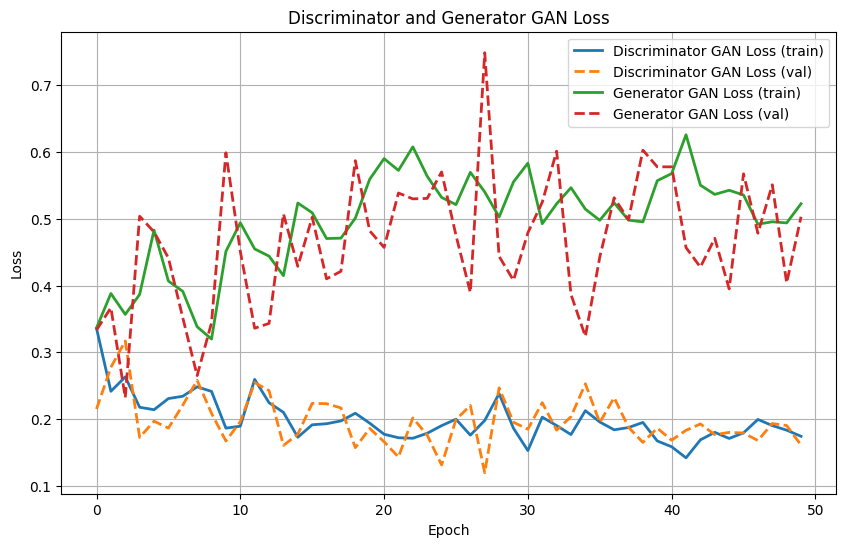

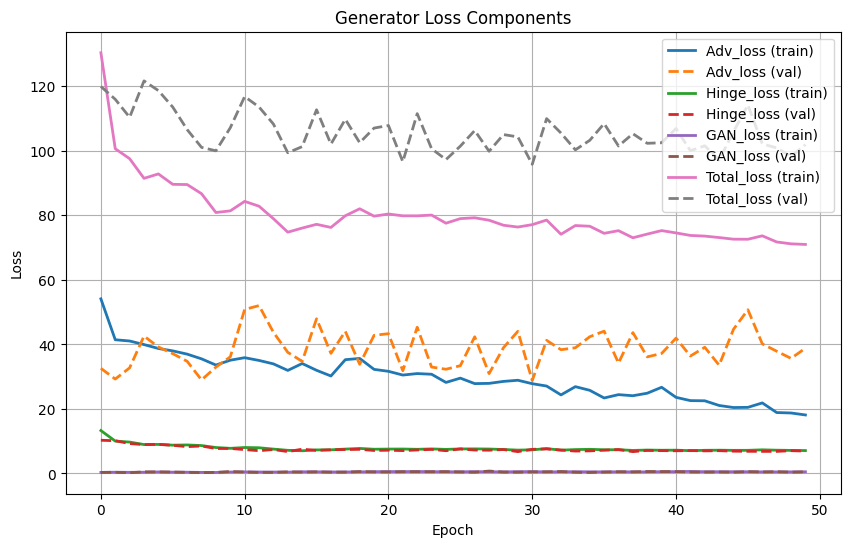

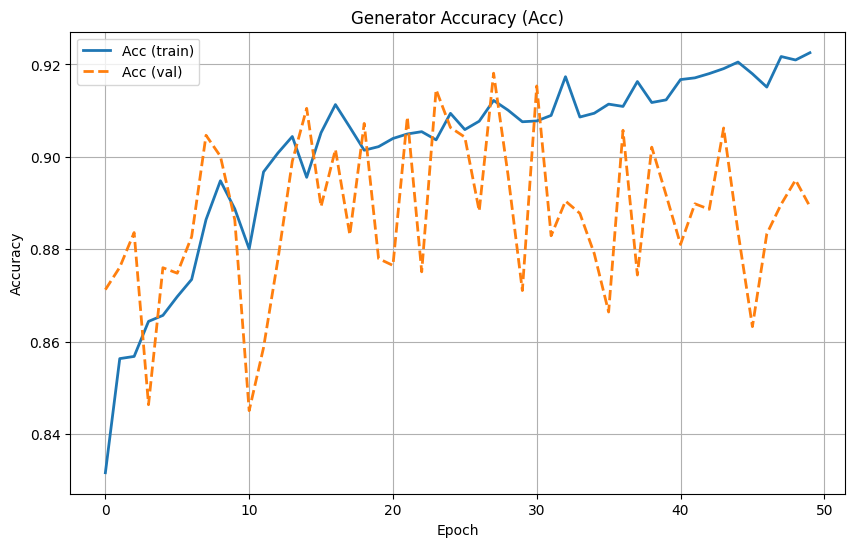

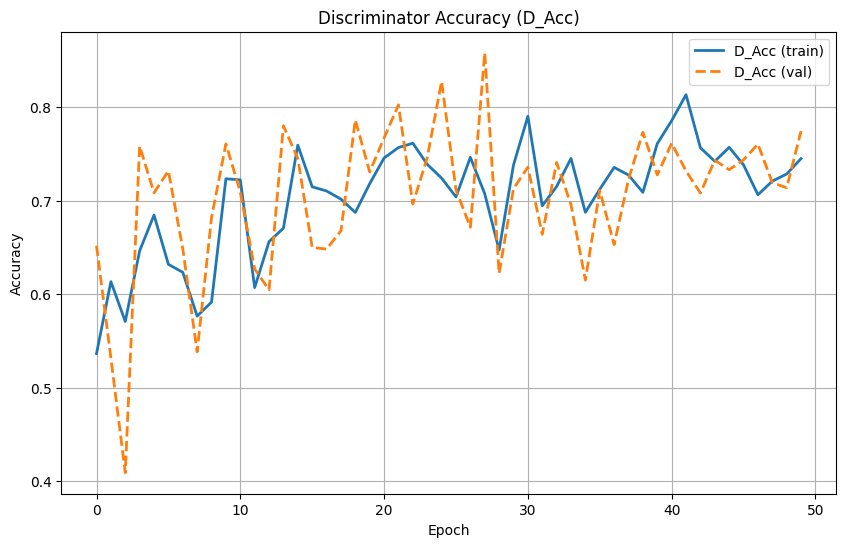

In [18]:
plot_training_history(history)

Performing Generator Attack: 100%|██████████| 79/79 [00:05<00:00, 15.76it/s]


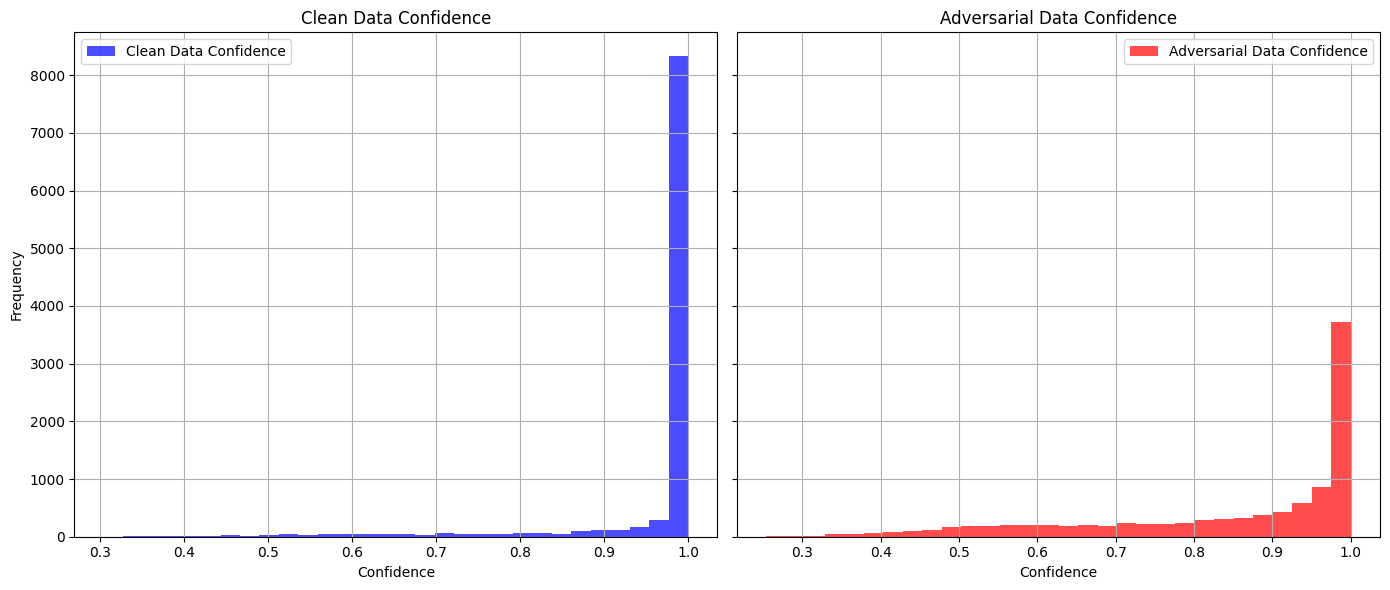

,Clean Accuracy,Adversarial Accuracy,Attack Success Rate
Overall,92.59,8.23,91.77
airplane,93.70,1.40,98.60
automobile,97.20,3.10,96.90
bird,90.10,13.10,86.90
cat,85.20,34.90,65.10
deer,92.90,3.50,96.50
dog,88.90,1.90,98.10
frog,94.40,0.50,99.50
horse,93.30,1.40,98.60
ship,95.70,15.50,84.50


In [25]:
perform_advgan_attack(generator_best, target_model, test_loader, CLASS_NAMES, TARGET, DEVICE)

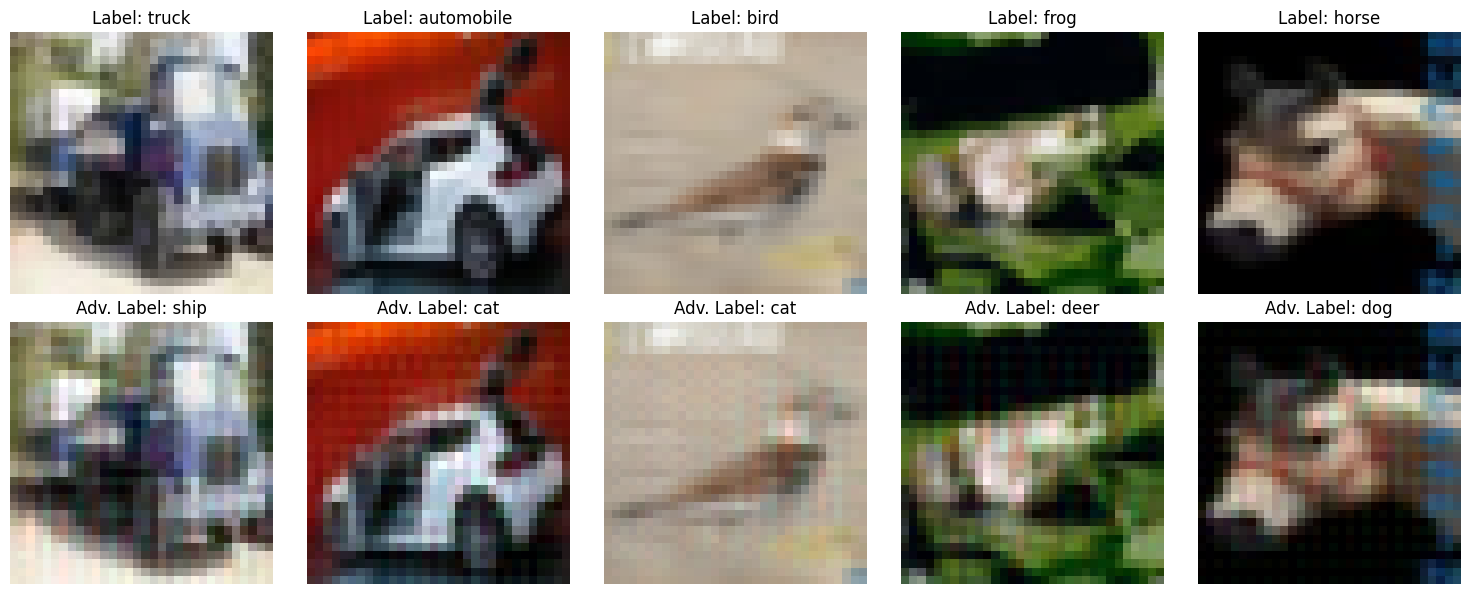

In [28]:
plot_images_with_advgan_attack(generator_best, target_model, test_loader, DEVICE)

## Targetted AdvGAN Attack

In [29]:
CLASS_NAMES.index('cat')

3

In [31]:
EPOCHS = 10
LR = 0.001
THRESHOLD = 8 / (255 * resnet20_std.max().item())
ALPHA = 15
BETA = 8
GAMMA = 0.35
NUM_STEPS = 10
TARGET = 3
IS_TARGETED = TARGET is not None

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator_CIFAR10_UNet().to(DEVICE)
discriminator = Discriminator_CIFAR10().to(DEVICE)
target_model = target_model.to(DEVICE)

history = train_gan(
    generator, discriminator, target_model, train_loader, val_loader, TARGET, IS_TARGETED, THRESHOLD,
    ALPHA, BETA, GAMMA, DEVICE, EPOCHS, NUM_STEPS, LR
)

Epoch 1/10
Train - Adv_Acc: 0.9367, D_Acc: 0.5234
Val   - Adv_Acc: 0.9679, D_Acc: 0.6080
--------------------------------------------------


Epoch 2/10
Train - Adv_Acc: 0.9540, D_Acc: 0.6885
Val   - Adv_Acc: 0.9607, D_Acc: 0.5166
--------------------------------------------------


Epoch 3/10
Train - Adv_Acc: 0.9586, D_Acc: 0.5691
Val   - Adv_Acc: 0.9519, D_Acc: 0.5433
--------------------------------------------------


Epoch 4/10
Train - Adv_Acc: 0.9588, D_Acc: 0.6771
Val   - Adv_Acc: 0.9931, D_Acc: 0.6355
--------------------------------------------------


Epoch 5/10
Train - Adv_Acc: 0.9577, D_Acc: 0.6283
Val   - Adv_Acc: 0.9694, D_Acc: 0.5489
--------------------------------------------------


Epoch 6/10
Train - Adv_Acc: 0.9583, D_Acc: 0.6890
Val   - Adv_Acc: 0.9789, D_Acc: 0.6211
--------------------------------------------------


Epoch 7/10
Train - Adv_Acc: 0.9574, D_Acc: 0.6090
Val   - Adv_Acc: 0.9658, D_Acc: 0.3712
--------------------------------------------------


Epoch 8/10
Train - Adv_Acc: 0.9581, D_Acc: 0.5922
Val   - Adv_Acc: 0.8246, D_Acc: 0.6575
--------------------------------------------------


Epoch 9/10
Train - Adv_Acc: 0.9616, D_Acc: 0.5957
Val   - Adv_Acc: 0.9976, D_Acc: 0.6382
--------------------------------------------------


Epoch 10/10
Train - Adv_Acc: 0.9626, D_Acc: 0.5796
Val   - Adv_Acc: 0.9787, D_Acc: 0.5792
--------------------------------------------------


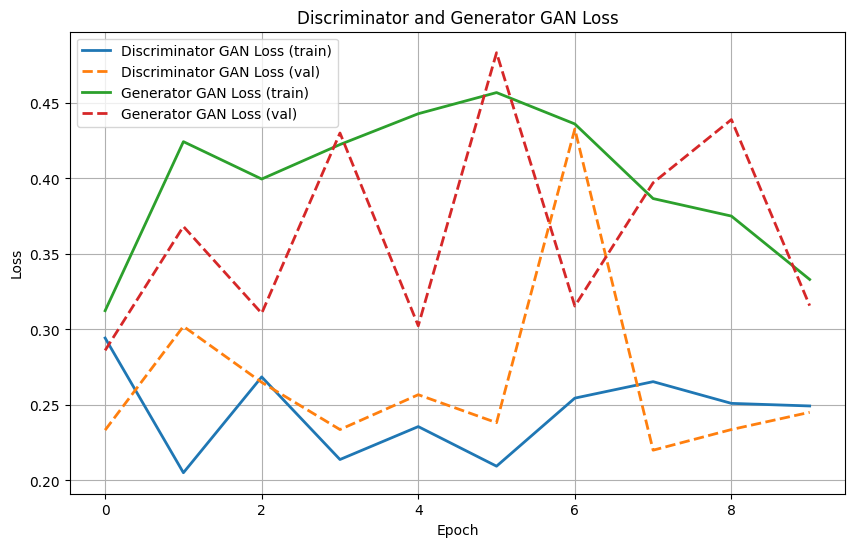

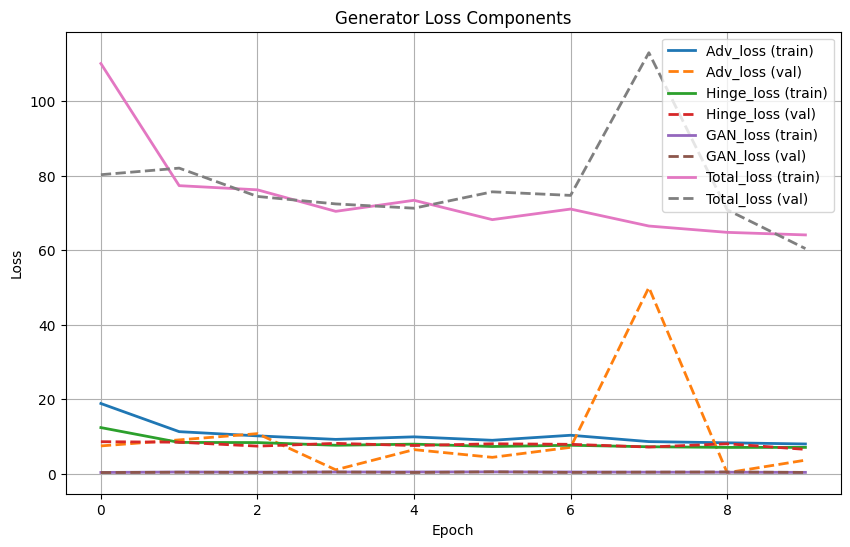

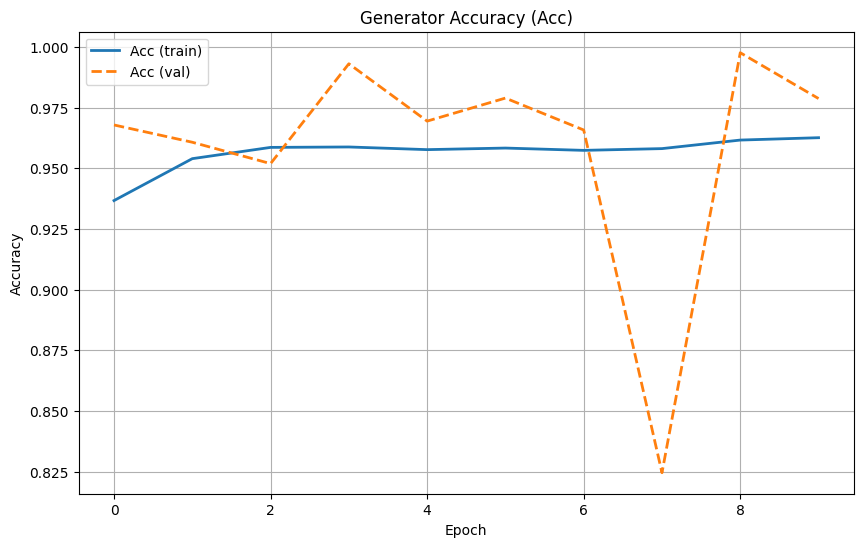

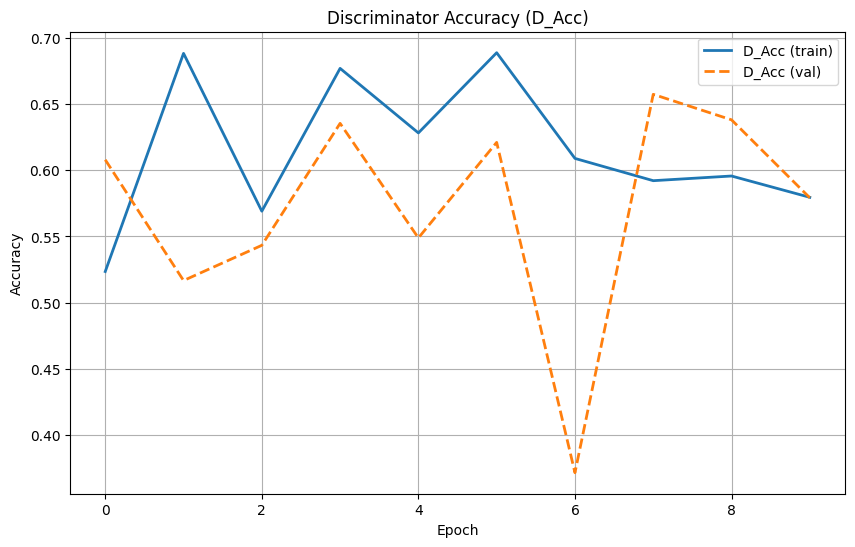

In [33]:
plot_training_history(history)

In [32]:
generator_best = Generator_CIFAR10_UNet().to(DEVICE)
generator_best.load_state_dict(torch.load("best_generator.pth", weights_only=True))

<All keys matched successfully>

Performing Generator Attack: 100%|██████████| 79/79 [00:04<00:00, 16.17it/s]


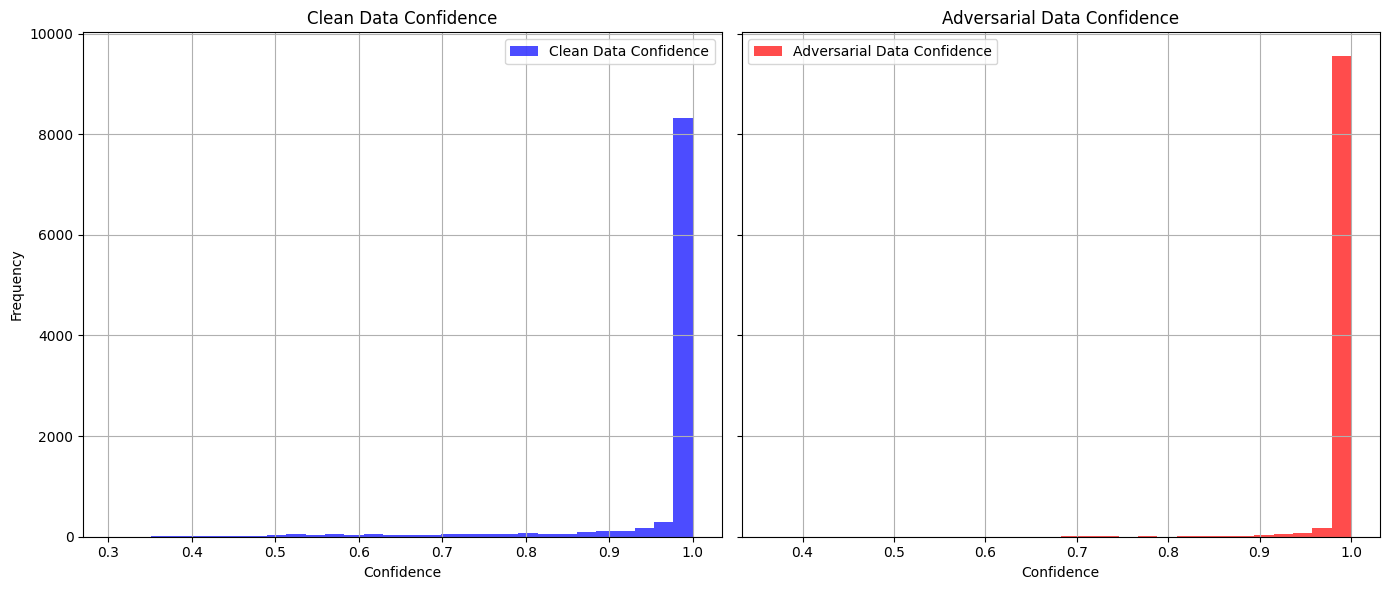

,Clean Accuracy,Adversarial Accuracy,Attack Success Rate
Overall,92.59,10.09,99.88
airplane,93.70,0.00,100.00
automobile,97.20,0.00,99.90
bird,90.10,0.40,99.60
cat,85.20,100.00,100.00
deer,92.90,0.10,99.90
dog,88.90,0.30,99.50
frog,94.40,0.00,100.00
horse,93.30,0.10,99.90
ship,95.70,0.00,100.00


In [34]:
perform_advgan_attack(generator_best, target_model, test_loader, CLASS_NAMES, TARGET, DEVICE)

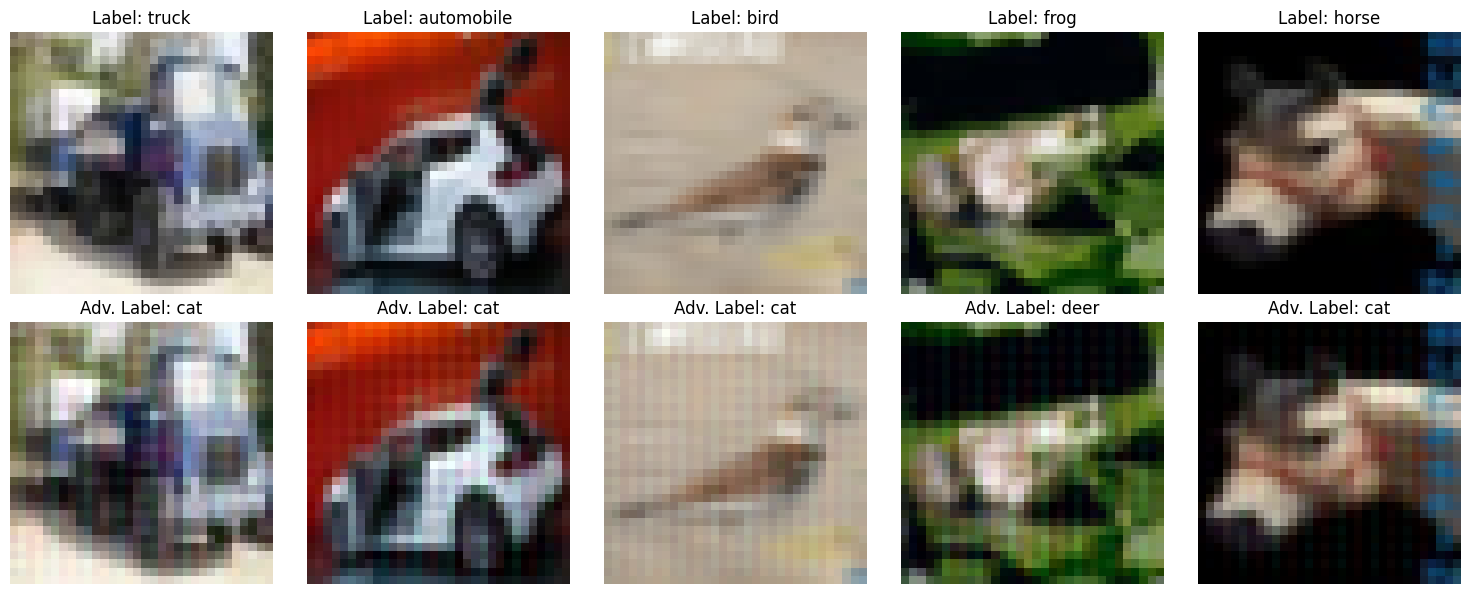

In [35]:
plot_images_with_advgan_attack(generator, target_model, test_loader)